Importar librerias

In [194]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
# Importamos la librería de pandas
import pandas as pd
import re
import matplotlib as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Cargar Datos

In [195]:
# Si nuestro archivo csv que estamos leyendo esta separado por comas
df_train = pd.read_csv("./.././Entrenamiento.csv", encoding='utf-8', index_col = False, usecols = [3,4,5,6,8,9,10,11])

# Corrige el error de lectura del archivo, pasa de string/objetc a float
df_train = df_train.replace('[^\d.]','', regex=True).astype(float) 

df_train.head()
#df_train.info()


,RSSI,Ang_azimuth,Ang_elevacion,Canal,Altura_ant(cm),Distancia_entre_ant_tag(cm),Altura_tag(cm),Error_dato_medido
0,-60.0,-9.0,-12.0,37.0,134.0,30.0,130.0,0.0
1,-60.0,-8.0,-6.0,37.0,134.0,30.0,130.0,0.0
2,-56.0,-9.0,-12.0,38.0,134.0,30.0,130.0,0.0
3,-63.0,-9.0,-12.0,37.0,134.0,30.0,130.0,0.0
4,-59.0,-8.0,-6.0,37.0,134.0,30.0,130.0,0.0


In [ ]:
df_train.info()

In [196]:
df_test = pd.read_csv("./.././Test.csv", encoding ='utf-8',index_col = False, usecols = [3,4,5,6,8,9,10,11])
df_test = df_test.replace('[^\d.]','', regex=True).astype(float) 
df_test.head()

,RSSI,Ang_azimuth,Ang_elevacion,Canal,Altura_ant(cm),Distancia_entre_ant_tag(cm),Altura_tag(cm),Error_dato_medido
0,-52.0,-6.0,-6.0,38.0,134.0,60.0,130.0,0.0
1,-46.0,-6.0,-6.0,39.0,134.0,60.0,130.0,0.0
2,-56.0,-6.0,-6.0,37.0,134.0,60.0,130.0,0.0
3,-48.0,-6.0,-6.0,39.0,134.0,60.0,130.0,0.0
4,-54.0,-6.0,-6.0,37.0,134.0,60.0,130.0,0.0


In [ ]:
# Eliminando variables sin datos
#df_train[df_train.Canal.isna()==True]

In [ ]:
#df_test[df_test.Canal.isna()==True]

In [ ]:
# observemos el tipo de los datos
#df_train.dtypes

In [ ]:
#df_test.dtypes

Preparación de los datos

In [197]:
# Escalamos los datos
scaler = MinMaxScaler()
scaler = scaler.fit(df_train)

df_train[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant(cm)','Distancia_entre_ant_tag(cm)','Altura_tag(cm)','Error_dato_medido']] = scaler.transform (df_train[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant(cm)','Distancia_entre_ant_tag(cm)','Altura_tag(cm)','Error_dato_medido']])
df_test[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant(cm)','Distancia_entre_ant_tag(cm)','Altura_tag(cm)','Error_dato_medido']] = scaler.transform (df_test[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant(cm)','Distancia_entre_ant_tag(cm)','Altura_tag(cm)','Error_dato_medido']])


In [198]:
# Creamos el dataset
def create_dataset (X, y, times_steps = 1):
    Xs, ys = [],[]
    for i in range(len(X)- times_steps):
        v = X.iloc[i:(i+ times_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+ times_steps])
    return np.array(Xs), np.array(ys)

In [199]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20754 entries, 0 to 20753
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RSSI                         20754 non-null  float64
 1   Ang_azimuth                  20754 non-null  float64
 2   Ang_elevacion                20754 non-null  float64
 3   Canal                        20754 non-null  float64
 4   Altura_ant(cm)               20754 non-null  float64
 5   Distancia_entre_ant_tag(cm)  20754 non-null  float64
 6   Altura_tag(cm)               20754 non-null  float64
 7   Error_dato_medido            20754 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [200]:
time_steps = 24*30

X_train , y_train = create_dataset(df_train, df_train.Error_dato_medido,time_steps)
X_test , y_test = create_dataset(df_test, df_test.Error_dato_medido,time_steps)

print(X_train.shape,y_train.shape)

(20034, 720, 8) (20034,)


Creación y entrenamiento del modelo

In [201]:
# Red neuronal, regresión lineal sencilla

oculta1 = tf.keras.layers.Dense(units = 64, input_shape = (X_train.shape[1], X_train.shape[2]))
oculta2 = tf.keras.layers.Dense(units = 64)
salida = tf.keras.layers.Dense(units = 1)
modelo = tf.keras.Sequential([oculta1, oculta2, salida])

modelo.compile(
    loss = "mean_squared_error", #tf.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001)
)

In [202]:
# Si no mejora lo vamos a desconectar
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 3)

In [203]:
history = modelo.fit(
    X_train,
    y_train,
    epochs = 10,   #10 iteraciones
    batch_size = 64,
    validation_split = 0.2, # esto es para que use el 20% de los datos para validación
    verbose = 1, #para que nos muestre los datos
    #shuffle = False, #En sistemas temporales esto si es importante decirle que no mezcle los datos
    callbacks = [callback]

)

Epoch 1/10
 34/251 [===>..........................] - ETA: 12s - loss: 0.2877

KeyboardInterrupt: 

In [211]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [ ]:
# Queremos hacer una predicción

y_pred = modelo.predict(X_test)


In [ ]:
plt.plot(y_test, label = 'Real')
plt.plot(y_pred[:,1], label = 'Predicted')
plt.legend()

In [ ]:
# Red neuronal, regresión lineal sencilla

oculta1 = tf.keras.layers.Dense(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))
oculta2 = tf.keras.layers.Dense(units = 64, activation = 'relu')
oculta3 = tf.keras.layers.Dense(units = 128, activation = 'relu')
salida = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
modelo_2 = tf.keras.Sequential([oculta1, oculta2, oculta3, salida])

modelo_2.compile(
    loss = "mean_squared_error",
    optimizer = tf.keras.optimizers.Adam(0.001)
)

In [ ]:
# Si no mejora lo vamos a desconectar
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 3)

In [ ]:
history = modelo_2.fit(
    X_train,
    y_train,
    epochs = 10,   #10 iteraciones
    batch_size = 64,
    validation_split = 0.2, # esto es para que use el 20% de los datos para validación
    verbose = 1, #para que nos muestre los datos
    #shuffle = False, #En sistemas temporales esto si es importante decirle que no mezcle los datos
    callbacks = [callback]

)

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [ ]:
y_pred = modelo_2.predict(X_test)

In [ ]:
plt.plot(y_test, label = 'Real')
plt.plot(y_pred[:,1], label = 'Predicted')
plt.legend()

Nueva red

In [ ]:
X_train.shape[0]

In [204]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten
from keras.layers import Convolution2D as Conv2D


In [205]:
# Red neuronal, regresión lineal sencilla

modelo_3 = Sequential()
modelo_3.add(Conv2D(4,(5,5), activation = 'relu', input_shape =(X_train.shape[1],X_train.shape[2],1)))
modelo_3.add(MaxPooling2D(pool_size = (2,2)))

modelo_3.add(Flatten())
modelo_3.add(Dense(32, activation = 'relu'))
modelo_3.add(Dropout(0.5))
modelo_3.add(Dense(1,activation = 'sigmoid'))

#oculta1 = tf.keras.layers.Dense(units = 128, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2]))
#oculta2 = tf.keras.layers.Dense(units = 64, activation = 'relu')
#oculta3 = tf.keras.layers.Dense(units = 128, activation = 'relu')
#salida = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
#modelo_3 = tf.keras.Sequential([oculta1, oculta2, oculta3, salida])

	
modelo_3.compile(optimizer='sgd', loss='mean_squared_error',metrics=['accuracy'])

#modelo_3.compile(
#    loss = "mean_squared_error",
#    optimizer = tf.keras.optimizers.Adam(0.001)
#)

In [206]:
modelo_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 716, 4, 4)         104       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 358, 2, 4)        0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 2864)              0         
                                                                 
 dense_20 (Dense)            (None, 32)                91680     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                     

In [207]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 3)

In [208]:
history = modelo_3.fit(
    X_train,
    y_train,
    epochs = 20,   #10 iteraciones
    batch_size = 64,
    validation_split = 0.1, # esto es para que use el 20% de los datos para validación
    verbose = 1, #para que nos muestre los datos
    #shuffle = False, #En sistemas temporales esto si es importante decirle que no mezcle los datos
    #callbacks = [callback]
)

Epoch 1/20
282/282 [==============================] - 13s 40ms/step - loss: 0.2127 - accuracy: 0.6627 - val_loss: 0.1392 - val_accuracy: 0.9900
Epoch 2/20
282/282 [==============================] - 10s 34ms/step - loss: 0.1072 - accuracy: 0.8884 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 3/20
282/282 [==============================] - 10s 35ms/step - loss: 0.0582 - accuracy: 0.9448 - val_loss: 0.0367 - val_accuracy: 0.9865
Epoch 4/20
282/282 [==============================] - 10s 35ms/step - loss: 0.0421 - accuracy: 0.9583 - val_loss: 0.0204 - val_accuracy: 0.9890
Epoch 5/20
282/282 [==============================] - 12s 41ms/step - loss: 0.0338 - accuracy: 0.9667 - val_loss: 0.0198 - val_accuracy: 0.9895
Epoch 6/20
282/282 [==============================] - 11s 39ms/step - loss: 0.0298 - accuracy: 0.9692 - val_loss: 0.0159 - val_accuracy: 0.9910
Epoch 7/20
282/282 [==============================] - 12s 42ms/step - loss: 0.0260 - accuracy: 0.9723 - val_loss: 0.0151 - val_accuracy:

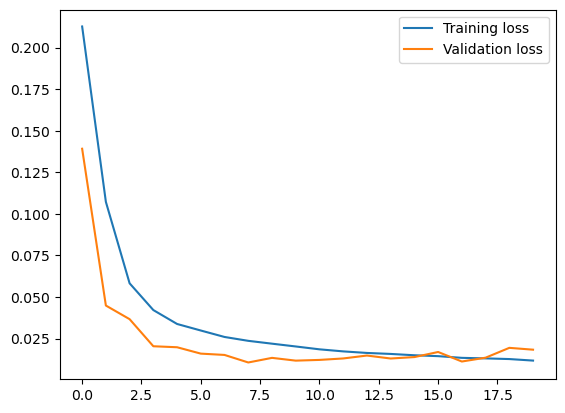

In [212]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [213]:
y_pred = modelo_3.predict(X_test)

222/222 [==============================] - 1s 4ms/step


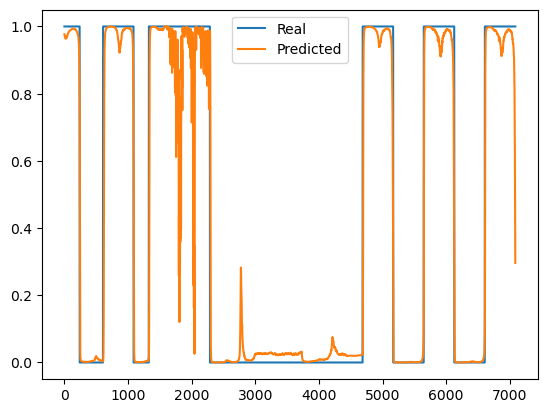

In [214]:
plt.plot(y_test, label = 'Real')
plt.plot(y_pred, label = 'Predicted')
plt.legend()

Graficar

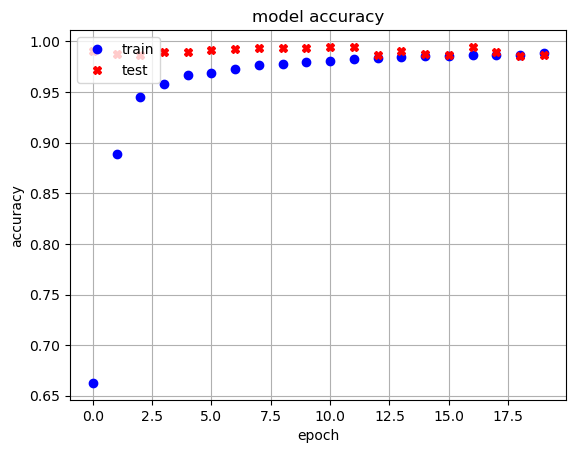

In [218]:
plt.plot(history.history['accuracy'],'bo')
plt.plot(history.history['val_accuracy'],'rX')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.grid()
plt.show()



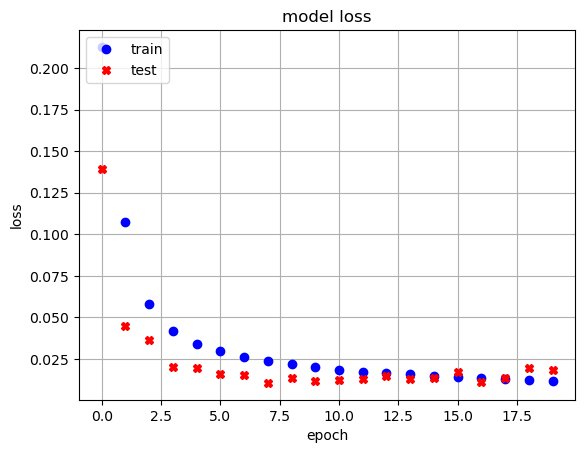

In [219]:
plt.plot(history.history['loss'],'bo')
plt.plot(history.history['val_loss'],'rX')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.grid()
plt.show()

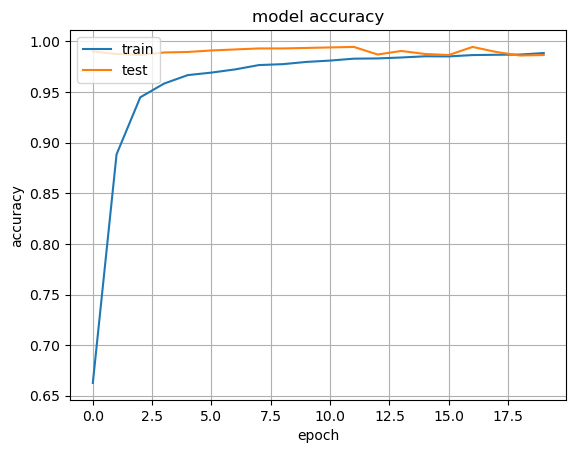

In [221]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.grid()
plt.show()

In [225]:
modelo_3.save('LOS_20iteraciones_pc.h5')

In [224]:
# Serializa el modelo para JSON
model_JSON = modelo_3.to_json()
name_json = "model.json"
with open(name_json, "w") as json_file:
    json_file.write(model_JSON)

# Serializar los pesos (weights) para HDF5
modelo_3.save_weights("model.h5")
print("Modelo guardado en el PC")



Modelo guardado en el PC


In [223]:
from keras.models import model_from_json

In [ ]:

# carga el json y crea el modelo
json_file = (name_json,'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
loaded_model.load_weights("model.h5")
print("Modelo cargado desde el PC")
# se evalua el modelo cargado con los datos de los test